In [1]:
# Define libraries
import pandas as pd
import numpy as np
import joblib

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.pipeline import Pipeline  
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Load your data
df = pd.read_csv('../data/transactions_users_100.csv')

In [3]:
# Define categorical and numerical columns
categorical_features = ['Use Chip', 'Merchant State', 'Errors?', 'time_of_day','Has Chip','International','Online','day_of_week']
numerical_features = [
    'Amount', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt', 
    'FICO Score', 'Num Credit Cards' , 'Cards Issued', 'Age_at_transaction', 'income_to_debt' , 'distances'
]

In [4]:
# Define the target variable
target = 'Is Fraud?'

In [5]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create the pipeline with RandomUnderSampler and preprocessing
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('undersampler', RandomUnderSampler(random_state=42)),
        ('classifier', model)
    ])

In [6]:
# Split the data into training and testing sets
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Perform grid search with the pipeline, reduced n_jobs, and error_score='raise' for detailed errors
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1, error_score='raise')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Amount',
                                                                          'Per '
                                                                          'Capita '
                                                                          'Income '
                                                                          '- '
                                                                          'Zipcode',
                                                                          'Yearly '
                                                                          'Income '
                                                                          '- '
                                                                          'Person',
                                                                          'Total '
                                                                          'Debt',
                                                                          'FICO '
                                                                          'Score',
                                                                          'Num '
                                                                          'Credit '
                                                                          'Cards',
                                                                          'Cards '
                                                                          'Issued',
                                                                          'Ag...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 6, 10],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='accuracy')

In [10]:
# Best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("\nBest Parameters:")
print(best_params)


Best Parameters:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [11]:
# Save the model
model_filename = 'trained_model100_xgboost.joblib'
joblib.dump(best_estimator, model_filename)
print(f"Model saved to {model_filename}")

# Load the model
loaded_model = joblib.load(model_filename)
print("Model loaded successfully")

Model saved to trained_model100_xgboost.joblib
Model loaded successfully


In [12]:
# Predict using the loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Evaluation
print('\nClassification Report (XGBoost):')
print(classification_report(y_test, y_pred_loaded))
print('Confusion Matrix (XGBoost):')
print(confusion_matrix(y_test, y_pred_loaded))
print('Accuracy Score (XGBoost):')
print(accuracy_score(y_test, y_pred_loaded))


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    240503
           1       0.01      0.93      0.02       224

    accuracy                           0.92    240727
   macro avg       0.51      0.93      0.49    240727
weighted avg       1.00      0.92      0.96    240727

Confusion Matrix (XGBoost):
[[221697  18806]
 [    15    209]]
Accuracy Score (XGBoost):
0.9218159990362527


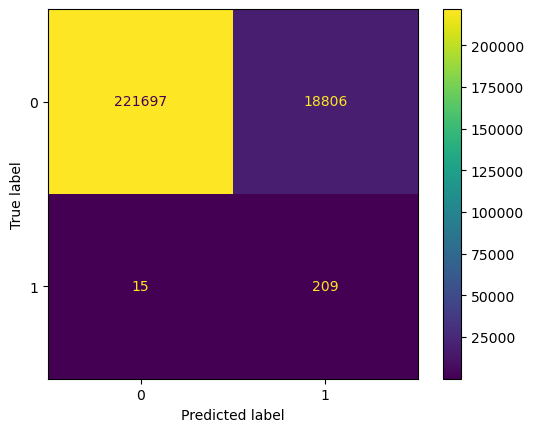

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting on the training set
y_test_pred = loaded_model.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [14]:
# Drop the target column and select the first row as a DataFrame
x = df.drop(columns=["Is Fraud?"]).iloc[[0]]

# Predict using the loaded model
prediction = loaded_model.predict(x)

# Create a dictionary from the selected row
pred_dict = x.iloc[0].to_dict()

# Print the dictionary items
for key, value in pred_dict.items():
    print(f"{key}: {value}")

# Print the prediction
print(f"Prediction: {prediction[0]}")

Amount: 134.09
Use Chip: Swipe Transaction
Merchant State: CA
Errors?: No Error
Per Capita Income - Zipcode: 29278
Yearly Income - Person: 59696
Total Debt: 127613
FICO Score: 787
Num Credit Cards: 5
Has Chip: 1
Cards Issued: 2
International: 0
Online: 0
Age_at_transaction: 36
income_to_debt: 0.4677893281422008
day_of_week: 6
time_of_day: Morning
distances: 0.0
Prediction: 0


In [15]:
# Select a row with 'Is Fraud?' == 1
fraud_row = df[df["Is Fraud?"] == 1].iloc[[0]]  # We can change the index if you have multiple fraud rows

# Drop the target column from the selected row
x_fraud = fraud_row.drop(columns=["Is Fraud?"])

# Predict using the loaded model
prediction_fraud = loaded_model.predict(x_fraud)

# Create a dictionary from the selected row
pred_dict_fraud = x_fraud.iloc[0].to_dict()

# Print the dictionary items
for key, value in pred_dict_fraud.items():
    print(f"{key}: {value}")

# Print the prediction
print(f"Prediction: {prediction_fraud[0]}")

Amount: 287.13
Use Chip: Online Transaction
Merchant State: Online Transaction
Errors?: No Error
Per Capita Income - Zipcode: 29278
Yearly Income - Person: 59696
Total Debt: 127613
FICO Score: 787
Num Credit Cards: 5
Has Chip: 1
Cards Issued: 2
International: 0
Online: 1
Age_at_transaction: 49
income_to_debt: 0.4677893281422008
day_of_week: 6
time_of_day: Afternoon
distances: 0.0
Prediction: 1
